# Graphs for data exploration - Austin Chalk edition



In [1]:
from pathlib import Path

import cartopy
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import numpy as np
import pandas as pd
import seaborn as sns
import shapefile
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

sns.set(style="whitegrid")
wdir = Path("EDA plots")

In [2]:
df = pd.read_parquet("austin_chalk_ml_vars.parquet")

df["comp_year"] = df["treatment_date"].dt.year
df.loc[df["comp_year"].isna(), "comp_year"] = df.start_date.dt.year
for x in ["prop_injected_sum", "fluid_injected_sum"]:
    # print(x[:-4])
    df[x[:-4] + "_length"] = df[x] / df["length_lateral"]

[Text(0.5, 0, 'EUR / lateral in log scale')]

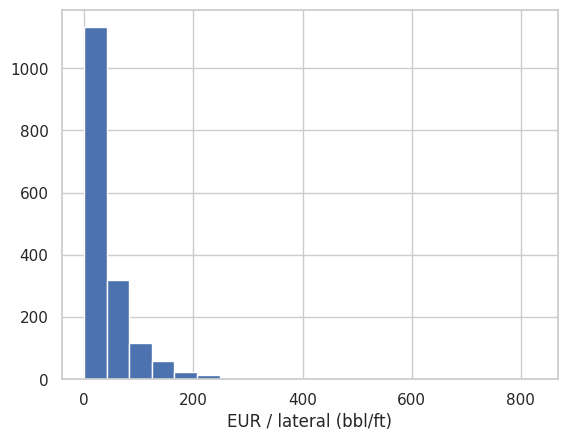

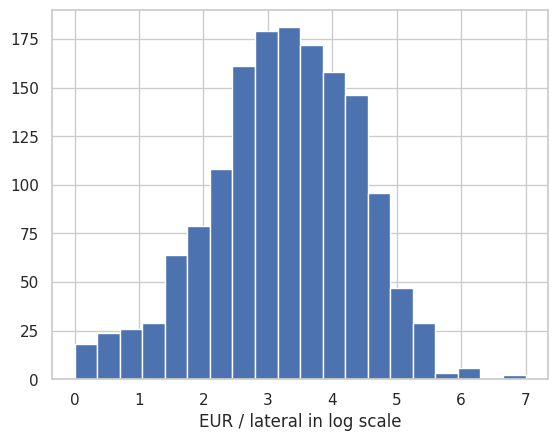

In [6]:
df.liquids_eur_length.hist(bins=20)
plt.gca().set(xlabel="EUR / lateral (bbl/ft)")
plt.figure()
df.liquids_eur_length.pipe(np.log).hist(bins=20, range=(0,7))
plt.gca().set(xlabel="EUR / lateral in log scale")

,gravity,gor,length_lateral,min_dist,prop_per_length_c,fluid_per_length_c,stages_number,Distance to nearest fault,Fault length,bearing,sinuosity
count,1107.000000,1692.000000,1680.000000,1768.000000,1190.000000,1190.000000,556.000000,246.000000,246.000000,246.000000,246.000000
mean,43.190786,497.956662,3926.261768,1795.435596,750.033759,650.060277,4.264388,2654.317748,31.989846,61.929423,1.005799
std,8.423918,3779.557882,1761.115291,970.968391,1147.388741,998.435237,9.491783,2926.451707,128.902418,22.058223,0.009821
min,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.010000,30.282333,1.000000
25%,37.750000,0.701433,2650.750000,736.712764,0.000000,0.000000,0.000000,142.645699,9.381000,56.620451,1.001121
50%,43.900000,3.763648,3937.000000,2600.000000,0.000000,0.000000,0.000000,1435.001493,12.506500,60.196167,1.002460
75%,49.500000,10.713675,5186.000000,2600.000000,1404.081601,1042.988660,0.000000,4138.759180,12.511000,65.422729,1.002515
max,66.300000,58109.423333,12797.000000,2600.000000,4967.465753,10478.000000,56.000000,10454.435350,993.600000,237.397111,1.058196


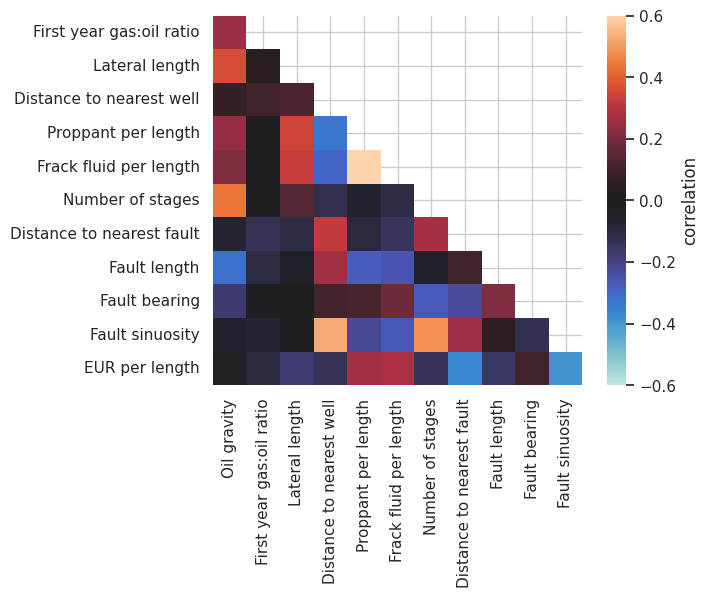

In [7]:
rename = {
    "gravity": "Oil gravity",
    "water_cut": "Water cut",
    "gor": "First year gas:oil ratio",
    "length_lateral": "Lateral length",
    "min_dist": "Distance to nearest well",
    "prop_per_length_c": "Proppant per length",
    "fluid_per_length_c": "Frack fluid per length",
    "stages_number": "Number of stages",
    "Distance to nearest fault": "Distance to nearest fault",
    "Fault length": "Fault length",
    "bearing": "Fault bearing",
    "sinuosity": "Fault sinuosity",
}
X_cols = [
    "gravity",
    #'water_cut',
    "gor",
    "length_lateral",
    "min_dist",
    "prop_per_length_c",
    "fluid_per_length_c",
    "stages_number",
    "Distance to nearest fault",
    "Fault length",
    "bearing",
    "sinuosity",
]

correlations = (
    df[X_cols]
    .rename(columns=rename)
    .join(df.liquids_eur_length.rename("EUR per length"))
    .corr()
)
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(
    correlations.iloc[1:, :-1],
    mask=mask[1:, :-1],
    square=True,
    cmap="icefire",
    vmin=-0.6,
    vmax=0.6,
    cbar_kws={"label": "correlation"},
)
df[X_cols].describe()

<Axes: >

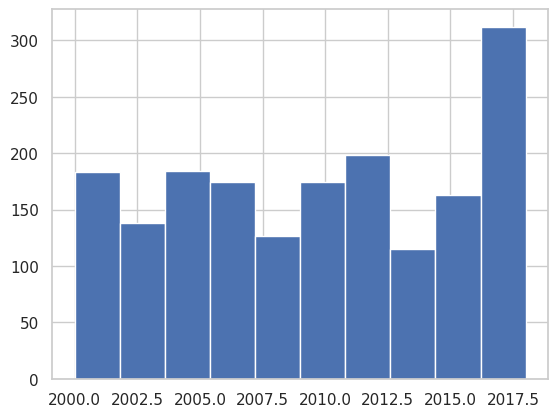

In [8]:
df.start_date.dt.year.hist()

# Intro figures

In [9]:
wells = pd.read_pickle("AC_results.pkl")
td = (
    pd.read_parquet("Terminal_decline_rates.parquet")
    .reset_index()
    .assign(API=lambda x: x.API.astype(str))
    .set_index("API")
)
wells = wells.join(td)

wells = wells.reset_index().assign(API=lambda x: x.API.astype(str)).set_index("API")
oil_cumprod = wells.liquids.apply(lambda x: np.cumsum(x.values))
i = 12
wells[f"cum_{i}m"] = oil_cumprod.apply(lambda x: x[i - 1] if len(x) >= i else np.nan)
wells[f"cum_{i}m_intensity"] = (wells[f"cum_{i}m"] / df.length_lateral).replace(
    np.inf, np.nan
)

In [10]:
data = df.assign(
    **{
        "Year completed": df["start_date"].dt.year,
        "Start quarter": df["start_date"] + pd.tseries.offsets.QuarterBegin(),
    }
)
data = data[(data["Year completed"] >= 2003) & (data["Year completed"] < 2020)]
data["Start year"] = data["Start quarter"] + pd.offsets.YearBegin()
data["Year completed"] = data["Year completed"].astype(int)
data["Terminal decline rate (%/y)"] = 100 * td["Terminal decline"]
data["Oil EUR (kbbl)"] = data.liquids_eur / 1e3
data["Oil EUR intensity (bbl/ft)"] = (
    data.loc[data["length_lateral"] > 500, "liquids_eur"] / data["length_lateral"]
)
data = data.join(wells[["cum_12m", "cum_12m_intensity"]])
data.loc[data.length_lateral < 50, f"cum_{i}m_intensity"] = np.nan

In [11]:
wells["State Name"].value_counts()

State Name
TEXAS        1712
LOUISIANA      56
Name: count, dtype: int64

In [12]:
data.Region.value_counts()

Region
Giddings         626
Karnes Trough    380
Brookeland       338
Pearsall         177
Name: count, dtype: int64

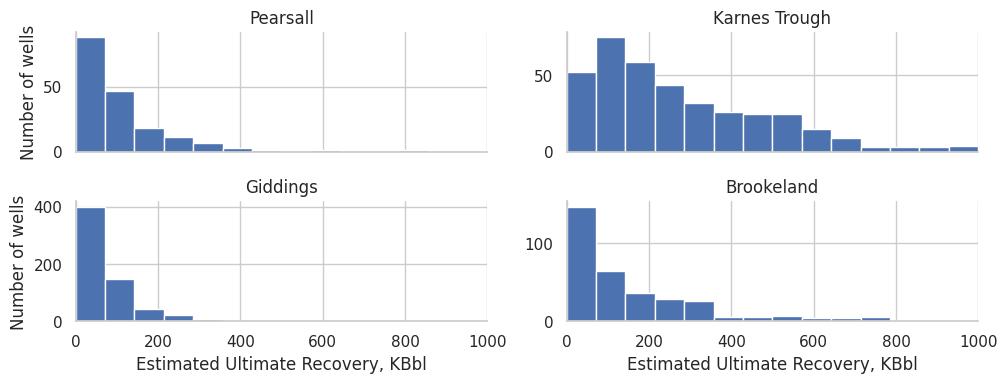

In [13]:
REGION_ORDER = ["Pearsall", "Karnes Trough", "Giddings", "Brookeland"]
g = sns.FacetGrid(
    data=data.assign(liquids_eur=lambda x: x.liquids_eur / 1e3),
    col="Region",
    col_order=REGION_ORDER,
    col_wrap=2,
    sharey=False,
    aspect=2.5,
    height=2,
    xlim=(0, 1000),
)
g.map(plt.hist, "liquids_eur", bins=np.linspace(0, 1000, 15))
g.set_axis_labels("Estimated Ultimate Recovery, KBbl", "Number of wells")
g.set_titles("{col_name}")
g.savefig(wdir / "Regional_EUR_distribution.png", bbox_inches="tight", dpi=450)

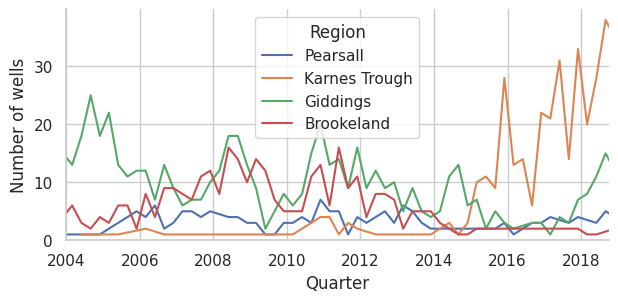

In [14]:
num_wells = (
    data.groupby(["Region", "Start quarter"])
    .count()
    .max(axis=1)
    .rename("Number of wells")
    .reset_index()
)
plt.figure(figsize=(7, 3))
g = sns.lineplot(
    data=num_wells,
    x="Start quarter",
    y="Number of wells",
    hue="Region",
    hue_order=REGION_ORDER,
)
g.set(xlim=pd.to_datetime(["2004-1-1", "2018-10-1"]), xlabel="Quarter", ylim=(0, None))
sns.despine()
plt.savefig(wdir / "number_of_wells.png", dpi=300, bbox_inches="tight")

<Axes: xlabel='Year'>

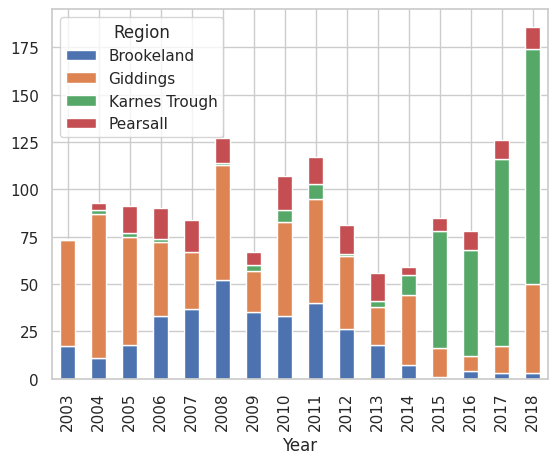

In [15]:
num_wells = (
    data.assign(Year=data.start_date.dt.year)
    .groupby(["Region", "Year"])
    .size()
    .reset_index()
    .pivot(columns="Region", index="Year", values=0)
)
num_wells.plot.bar(stacked=True)

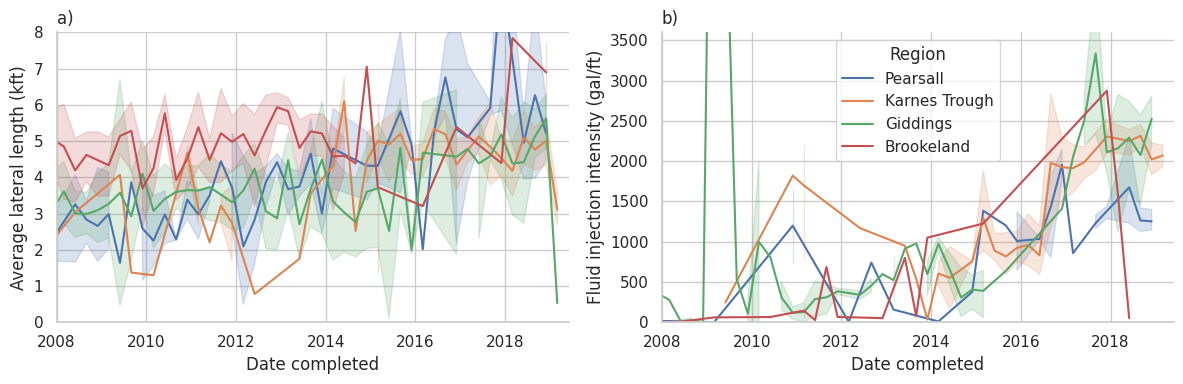

In [16]:
xlims = pd.to_datetime(["2008-1-1", "2019-6-1"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plt.sca(ax1)
sns.lineplot(
    x="Start quarter",
    y="length_lateral",
    hue="Region",
    data=data.assign(length_lateral=data.length_lateral / 1e3),
    hue_order=REGION_ORDER,
    legend=False,
    ax=ax1,
)
plt.xlabel("Date completed")
plt.ylabel("Average lateral length (kft)")
plt.xlim(*xlims)
plt.ylim(0, 8)
sns.despine()
ax1.set_title("a)", loc="left")

plt.sca(ax2)
sns.lineplot(
    x="Start quarter",
    y="fluid_per_length_c",
    hue="Region",
    data=data.query("fluid_per_length_c>.1"),
    hue_order=REGION_ORDER,  # color='k'
)
plt.xlabel("Date completed")
plt.ylabel("Fluid injection intensity (gal/ft)")
plt.xlim(*xlims)
plt.ylim(0, 3.6e3)
# plt.yscale('log')
sns.despine()
ax2.set_title("b)", loc="left")
plt.tight_layout()
plt.savefig(wdir / "Completion_length_fluid_overtime.png", dpi=300, bbox_inches="tight")

In [17]:
xlims = pd.to_datetime(["2008-1-1", "2019-6-1"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
plt.sca(ax1)
sns.lineplot(
    x="Start quarter",
    y="prop_injected_length",  # hue='Region',
    data=data,
    hue_order=REGION_ORDER,
    legend=False,
    color="steelblue",
)
ax1.set(xlabel="Date completed", ylabel="", xlim=xlims, ylim=(0,3e3)
ax1.set_title("a) Proppant injection intensity (lb/ft)", loc="left")
sns.despine()

sns.lineplot(
    x="Start quarter",
    y="fluid_injected_length",  # hue='Region',
    data=data.query("fluid_per_length_c>.1"),
    hue_order=REGION_ORDER,
    color="peru",
    ax=ax2,
)
ax2.set(xlabel="Date completed", ylabel="", xlim=xlims, ylim=(0,3e3)
ax2.set_title("b) Fluid injection intensity (gal/ft)", loc="left")
sns.despine()
fig.tight_layout()
fig.savefig(wdir / "Completion_overtime_grouped.png", dpi=300, bbox_inches="tight")

SyntaxError: invalid syntax. Perhaps you forgot a comma? (106350538.py, line 13)

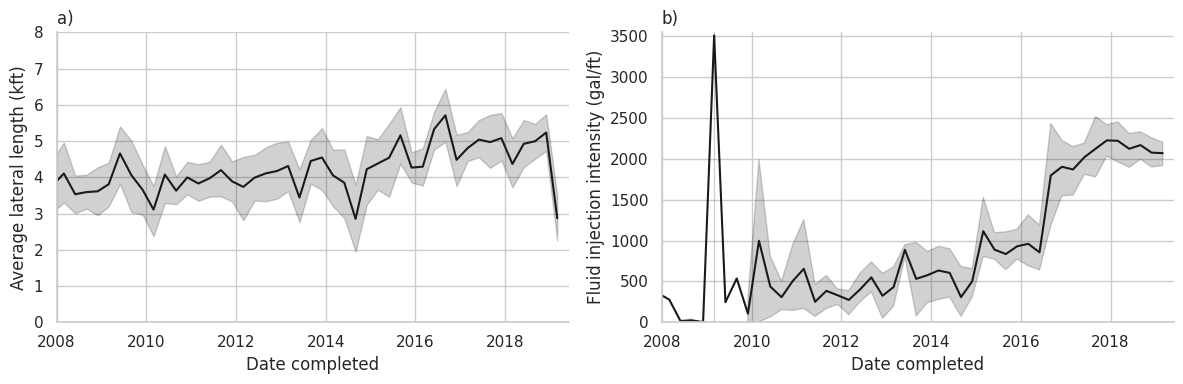

In [18]:
# data = df.copy()
xlims = pd.to_datetime(["2008-1-1", "2019-6-1"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plt.sca(ax1)
sns.lineplot(
    x="Start quarter",
    y="length_lateral",  # hue='Region',
    data=data.assign(length_lateral=data.length_lateral / 1e3),
    hue_order=REGION_ORDER,
    legend=False,
    color="k",
    ax=ax1,
)
ax1.set(xlabel="Date completed", ylabel="Average lateral length (kft)", xlim=xlims, ylim=(0,8))
sns.despine()
ax1.set_title("a)", loc="left")

plt.sca(ax2)
sns.lineplot(
    x="Start quarter",
    y="fluid_per_length_c",  # hue='Region',
    data=data.query("fluid_per_length_c>.1"),
    hue_order=REGION_ORDER,
    color="k",
    ax=ax2,
)
ax2.set(xlabel="Date completed", ylabel="Fluid injection intensity (gal/ft)", xlim=xlims, ylim=(0,3.55e3))
# plt.yscale('log')
sns.despine()
ax2.set_title("b)", loc="left")
fig.tight_layout()
fig.savefig(wdir / "Completion_overtime_grouped.png", dpi=300, bbox_inches="tight")

TypeError: lineplot() got multiple values for argument 'data'

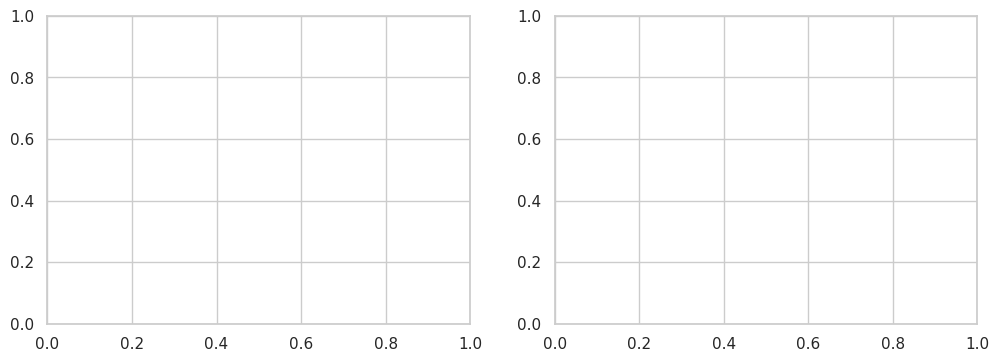

In [19]:
xlims = pd.to_datetime(["2004-1-1", "2019-6-1"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(
    "Start quarter",
    "tau_y",
    hue="Region",
    data=data,
    hue_order=REGION_ORDER,
    ax=ax1
)
ax1.xticks(rotation=90)
ax1.set(xlabel="Date well began prodution", ylabel="Time to BDF (years)", xlim=xlims, ylim=(0,None))
sns.despine()
ax1.set_title("a)", loc="left")

plt.sca(ax2)
sns.lineplot(
    "Start quarter",
    "Terminal decline rate (%/y)",
    hue="Region",
    data=data,
    hue_order=REGION_ORDER,
    ax=ax2,
)
ax2.xticks(rotation=90)
ax2.set(xlabel="Date well began prodution", xlim=xlims, ylim=(0,40))
sns.despine()
ax2.set_title("b)", loc="left")

fig.tight_layout()
fig.savefig(wdir / "Tau_tdecline_peryear.png", dpi=300, bbox_inches="tight")

TypeError: lineplot() got multiple values for argument 'data'

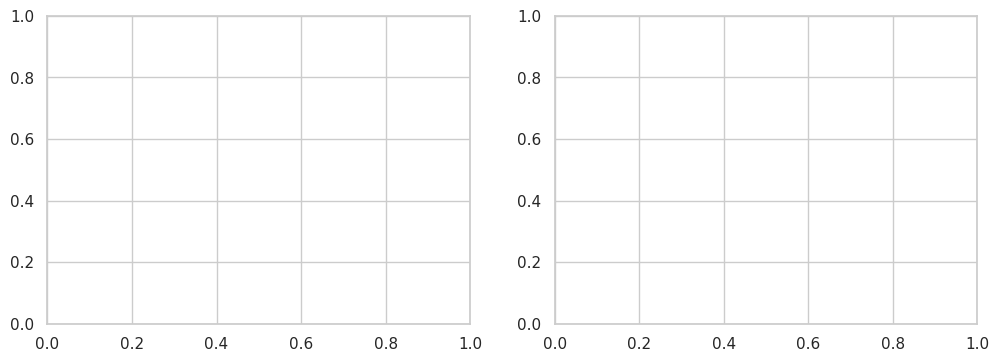

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plt.sca(ax1)
# sns.boxenplot('Year completed','Oil EUR (kbbl)',data=data,color=sns.palettes.get_color_cycle()[1])
sns.lineplot(
    "Start quarter",
    "Oil EUR (kbbl)",
    hue="Region",
    data=data,
    hue_order=REGION_ORDER,
    legend=False,
    ax=ax1
)
ax1.xticks(rotation=90)
ax1.set(xlabel="Date well began production", xlim=xlims, ylim=(0,700))
sns.despine()
ax1.set_title("a)", loc="left")

plt.sca(ax2)
sns.lineplot(
    "Start quarter",
    "Oil EUR intensity (bbl/ft)",
    hue="Region",
    data=data,
    hue_order=REGION_ORDER,
)  # ,color=sns.palettes.get_color_cycle()[3])
plt.xticks(rotation=90)
plt.xlabel("Date well began production")
plt.xlim(*xlims)
plt.ylim(0, 180)
sns.despine()
ax2.set_title("b)", loc="left")

plt.tight_layout()
plt.savefig(wdir + "EUR_peryear.png", dpi=300, bbox_inches="tight")

TypeError: lineplot() got multiple values for argument 'data'

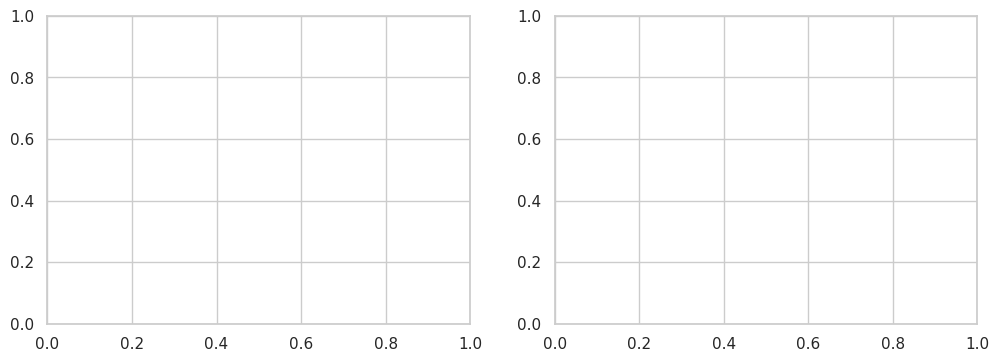

In [21]:
xlims = pd.to_datetime(["2004-1-1", "2019-5-1"])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plt.sca(ax1)
sns.lineplot(
    "Start quarter",
    "cum_12m",
    hue="Region",
    data=data.assign(cum_12m=lambda x: x.cum_12m / 1e3),
    hue_order=REGION_ORDER,
    ax=ax1,
)
plt.xticks(rotation=90)
ax1.set(xlabel="Date well began production",ylim=(0, 300), ylabel="12M cumulative oil (kbbl)")
sns.despine()
ax1.set_title("a)", loc="left")

plt.sca(ax2)
sns.lineplot(
    "Start quarter",
    "cum_12m_intensity",
    hue="Region",
    data=data,
    hue_order=REGION_ORDER,
)
plt.xlabel("Date well began production")
plt.xticks(rotation=90)
plt.ylim(0, 75)
plt.xlim(*xlims)
plt.ylabel("12M cumulative oil intensity (bbl/ft)")
sns.despine()
ax2.set_title("b)", loc="left")

plt.tight_layout()
plt.savefig(wdir + "Cum12m_peryear.png", dpi=300, bbox_inches="tight")

TypeError: unsupported operand type(s) for +: 'PosixPath' and 'str'

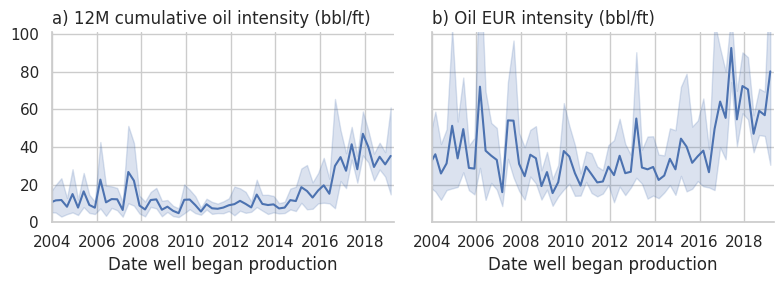

In [22]:
xlims = pd.to_datetime(["2004-1-1", "2019-5-1"])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

ax1.set_title("a) 12M cumulative oil intensity (bbl/ft)", loc="left")
sns.lineplot(x="Start quarter", y="cum_12m_intensity", data=data, ax=ax1)
ax1.set(xlabel="Date well began production", xlim=xlims, ylabel="", ylim=(0, 101))

sns.lineplot(
    x="Start quarter",
    y="Oil EUR intensity (bbl/ft)",
    data=data,
    ax=ax2,
    # color=sns.palettes.get_color_cycle()[4]
)
ax2.set(
    xlabel="Date well began production",
    xlim=xlims,
    # ylabel='Oil EUR intensity (bbl/ft)',
    ylim=(0, 101),
)
ax2.set_title("b) Oil EUR intensity (bbl/ft)", loc="left")

sns.despine()
plt.tight_layout()
plt.savefig(wdir + "Cum12m_eur.png", dpi=500, bbox_inches="tight")

TypeError: unsupported operand type(s) for +: 'PosixPath' and 'str'

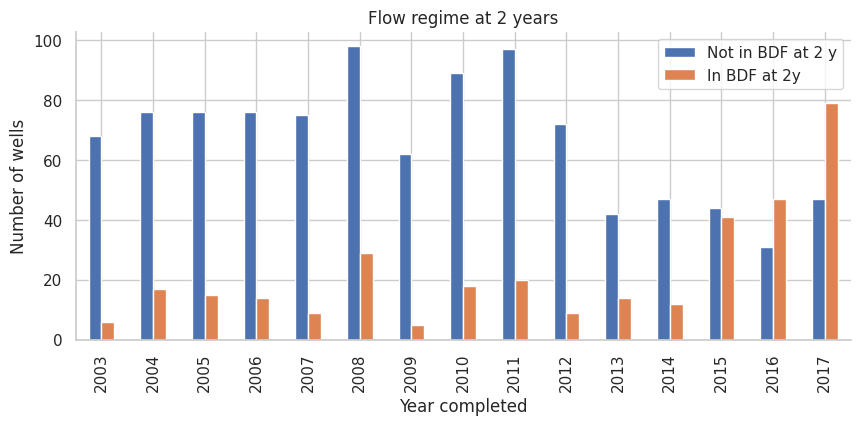

In [23]:
tau_y2 = data.groupby("Year completed")["tau_y"].aggregate(
    **{"Not in BDF at 2 y": lambda x: sum(x >= 4), "In BDF at 2y": lambda x: sum(x < 4)}
)
tau_y2.loc[:2017].plot.bar(figsize=(10, 4))
plt.ylabel("Number of wells")
plt.title("Flow regime at 2 years")
sns.despine()
plt.savefig(wdir + "Flow_regime_2y.png", dpi=300, bbox_inches="tight")

In [24]:
states = cartopy.feature.NaturalEarthFeature(
    category="cultural",
    scale="50m",
    facecolor="none",
    name="admin_1_states_provinces_shp",
)

clines = "shapefiles/tl_2017_us_county/tl_2017_us_county.shp"
counties = ShapelyFeature(
    cartopy.io.shapereader.Reader(clines).geometries(),
    ccrs.PlateCarree(),
    edgecolor="gray",
    facecolor="none",
)

headers = (
    pd.read_pickle("spacings_measured.pkl")
    .reset_index()
    .assign(UWI=lambda x: x.UWI.astype(str))
    .set_index("UWI")
    .join(df["liquids_eur"])
)

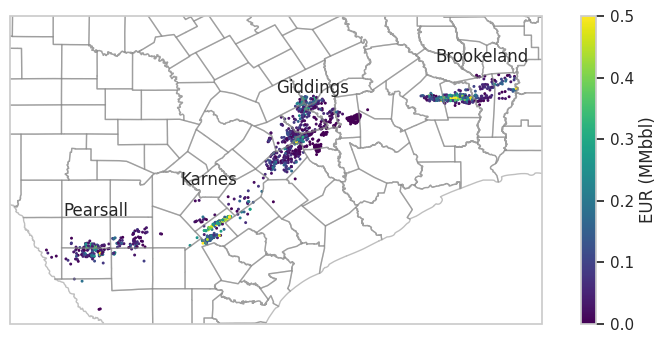

In [32]:
f = plt.figure(figsize=(10, 4))
ax = plt.axes(
    projection=ccrs.PlateCarree(),
)
h = headers[headers.surf_lat < 32.5]
plt.scatter(
    x=h["surf_lon"],
    y=h["surf_lat"],
    c=h["liquids_eur"] / 1e6,
    s=5,
    marker=".",
    cmap="viridis",  # sns.light_palette('green',as_cmap=True),
    vmax=0.5,
)
# ax.add_feature(states,edgecolor='black')
ax.add_feature(counties, edgecolor="gray", alpha=0.5)
ax.text(0.1, 0.35, "Pearsall", transform=ax.transAxes)
ax.text(0.32, 0.45, "Karnes", transform=ax.transAxes)
ax.text(0.5, 0.75, "Giddings", transform=ax.transAxes)
ax.text(0.8, 0.85, "Brookeland", transform=ax.transAxes)

plt.colorbar(label="EUR (MMbbl)", orientation="vertical")
f.savefig(wdir / "EUR_map.png", dpi=300, bbox_inches="tight")

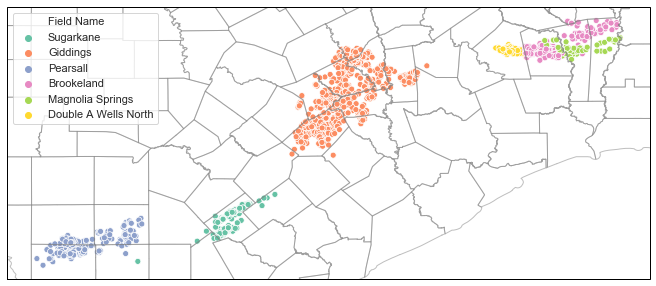

In [45]:
data = headers.join(
    wells.loc[
        lambda x: x["Field Name"].isin(x["Field Name"].value_counts().iloc[:7].index),
        "Field Name",
    ],
    how="inner",
)
data["Field Name"] = data["Field Name"].str.title()
f = plt.figure(figsize=(12, 5))
ax = plt.axes(
    projection=ccrs.PlateCarree(),
)
sns.scatterplot(data=data, x="surf_lon", y="surf_lat", hue="Field Name", palette="Set2")
ax.add_feature(counties, edgecolor="gray", alpha=0.5)
f.savefig(wdir + "Field map.png", dpi=300, bbox_inches="tight")

In [26]:
df["propping_type"].value_counts()

Unknown    1139
Sand         64
Name: propping_type, dtype: int64

In [27]:
df["fluid_type"].value_counts()

Unknown        659
Gel            251
Slick water    201
Water           63
Other           29
Name: fluid_type, dtype: int64

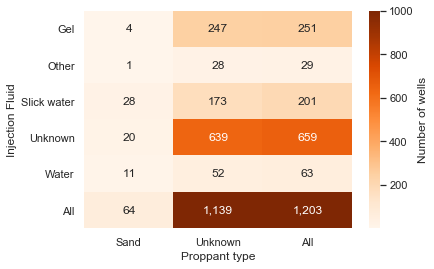

In [29]:
t = pd.crosstab(df["fluid_type"], df["propping_type"], margins=True)
sns.heatmap(
    t,
    cmap="Oranges",
    annot=True,
    fmt=",g",
    cbar_kws={"label": "Number of wells"},
    vmax=1e3,
)
plt.xlabel("Proppant type")
plt.ylabel("Injection Fluid")
plt.savefig(wdir + "injection_proppant_choices.png", dpi=300, bbox_inches="tight")

In [30]:
col_rename_dict = {
    "length_lateral": "Lateral length (ft)",
    "prop_per_fluid": "Proppant per fluid (lb/gal)",
    "fluid_injected_length": "Fluid intensity (gal/ft)",
    "prop_injected_length": "Proppant intensity (lb/ft)",
    "comp_year": "Year",
    "propping_type": "Proppant type",
    "fluid_type": "Injection fluid",
    "liquids_eur_length": "Normed EUR (bbl/ft)",
    "tau_y": "Time to BDF (y)",
    "water_cut": "Water cut",
    "gor": "Gas:oil ratio (Mcf/stb)",
}
out_cols = [
    "prop_per_fluid",
    "liquids_eur_length",
    "prop_injected_length",
    "fluid_injected_length",
    "length_lateral",
    "tau_y",
    "water_cut",
]
t_byfluid = (
    df.query("comp_year>2003")
    .assign(comp_year=lambda x: x.comp_year.astype(int).astype(str))
    .groupby(["comp_year", "fluid_type"])[out_cols]
    .mean()
    .reset_index()
    .rename(columns=col_rename_dict)
    .sort_values("Year")
)

t_byproppant = (
    df.query("comp_year>2003")
    .assign(comp_year=lambda x: x.comp_year.astype(int).astype(str))
    .groupby(["comp_year", "propping_type"])[out_cols]
    .mean()
    .reset_index()
    .rename(columns=col_rename_dict)
    .sort_values("Year")
)

## Length of lateral vs Proppant per fluid volume for each year

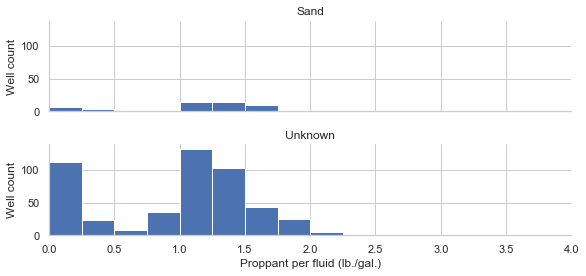

In [31]:
# df['prop_per_fluid'].hist(bins=np.arange(0,4.1,.25),)
g = sns.FacetGrid(
    df,
    row="propping_type",
    sharey=True,
    aspect=4,
    height=2,
    row_order=["Sand", "Unknown"],
)
g.map(
    plt.hist,
    "prop_per_fluid",
    bins=np.arange(0, 4.1, 0.25),
)
# sns.distplot('prop_per_fluid', data=df)
plt.xlabel("Proppant per fluid (lb./gal.)")
g.set_ylabels("Well count")
g.set_titles("{row_name}")
plt.xlim(0, 4)
sns.despine()

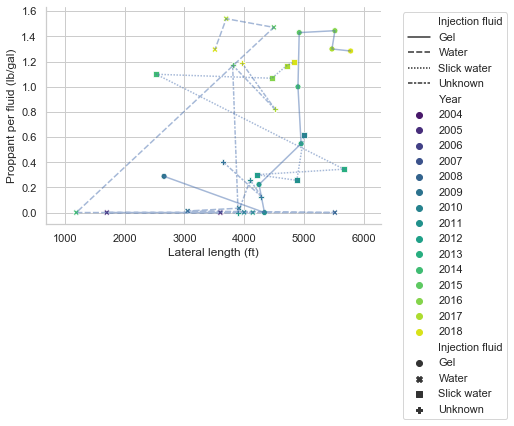

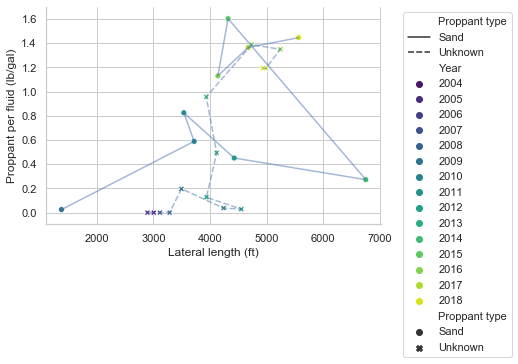

In [32]:
# Fluid type
g = sns.scatterplot(
    "Lateral length (ft)",
    "Proppant per fluid (lb/gal)",
    hue="Year",
    style="Injection fluid",
    data=t_byfluid,
    palette=sns.color_palette("viridis", len(t_byproppant.Year.unique())),
    style_order=["Gel", "Water", "Slick water", "Unknown"],
    legend="brief",
)
g = sns.lineplot(
    "Lateral length (ft)",
    "Proppant per fluid (lb/gal)",
    style="Injection fluid",
    data=t_byfluid,
    sort=False,
    style_order=["Gel", "Water", "Slick water", "Unknown"],  # legend=False,
    alpha=0.5,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.savefig(
    wdir + "Average_proppant_intensity_v_length_v_prop.png",
    dpi=300,
    bbox_inches="tight",
)
## Proppant type
plt.figure()

g = sns.scatterplot(
    "Lateral length (ft)",
    "Proppant per fluid (lb/gal)",
    hue="Year",
    style="Proppant type",
    data=t_byproppant,  # [t_byproppant.Year.isin(['2004','2011','2018'])],
    palette=sns.color_palette("viridis", len(t_byproppant.Year.unique())),
    style_order=["Sand", "Unknown"],
    legend="brief",
)
g = sns.lineplot(
    "Lateral length (ft)",
    "Proppant per fluid (lb/gal)",
    style="Proppant type",
    data=t_byproppant,
    sort=False,
    style_order=["Sand", "Unknown"],  # legend=False,
    alpha=0.5,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.savefig(
    wdir + "Average_proppant_intensity_v_length_v_inj.png", dpi=300, bbox_inches="tight"
)

## EUR per length vs proppant per fluid

EUR [and separately time to BDF] per length of lateral versus Proppant per fluid volume [for full data set and for each year, plotting slickwater and gel fracs and separately sand versus ceramic proppants with different symbols]

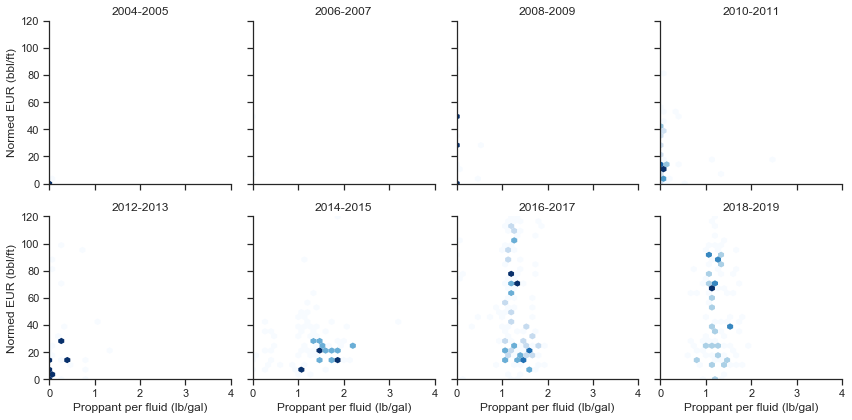

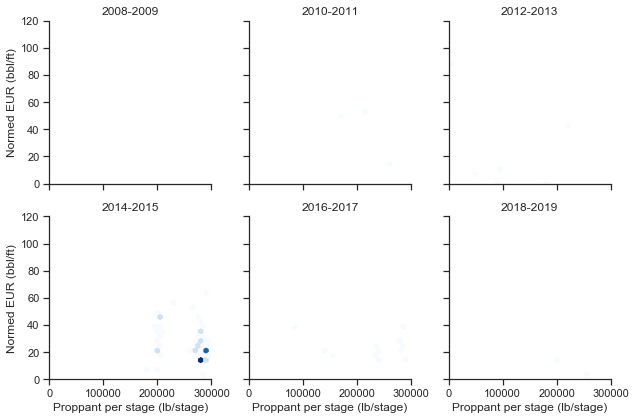

In [33]:
t = (
    df.query("liquids_eur_length < @df.liquids_eur_length.quantile(.99)")
    .query("comp_year > 2003")
    .assign(Years=lambda x: x["comp_year"] // 2 * 2)
    .assign(
        Years=lambda x: x.Years.astype(str).str[:-2]
        + "-"
        + (x.Years + 1).astype(str).str[:-2]
    )
    .rename(columns=col_rename_dict)
)
t["Proppant per stage (lb/stage)"] = t["prop_injected_sum"] / t["stages_number"]

with sns.axes_style("ticks"):
    # sns.jointplot('Proppant per fluid (lb./gal.)', 'Normed EUR (bbl/ft)', data=t, kind='hexbin',xlim=(0,4), ylim=(0,120))
    g = sns.FacetGrid(
        t,
        col="Years",
        col_wrap=4,
        xlim=(0, 4),
        ylim=(0, 120),
        col_order=t.Years.sort_values().unique(),
    )
    g.map(
        plt.hexbin,
        "Proppant per fluid (lb/gal)",
        "Normed EUR (bbl/ft)",
        extent=[0, 4, 0, 120],
        gridsize=30,
        cmap="Blues",
        mincnt=1,
        linewidths=0,
    )
    g.set_titles("{col_name}")
    plt.savefig(wdir + "EUR_v_prop_per_fluid.png", dpi=300, bbox_inches="tight")

with sns.axes_style("ticks"):
    g = sns.FacetGrid(
        t,
        col="Years",
        col_wrap=3,
        xlim=(0, 3e5),
        ylim=(0, 120),
        col_order=t.Years.sort_values().unique()[2:],
    )
    g.map(
        plt.hexbin,
        "Proppant per stage (lb/stage)",
        "Normed EUR (bbl/ft)",
        extent=[0, 3e5, 0, 120],
        gridsize=30,
        cmap="Blues",
        mincnt=1,
        linewidths=0,
    )
    g.set_titles("{col_name}")
    plt.savefig(wdir + "EUR_v_prop_per_stage.png", dpi=300, bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

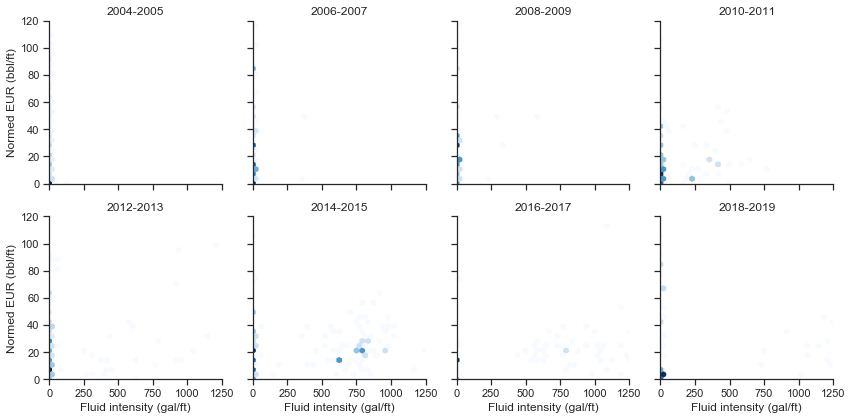

In [34]:
t = (
    df.query(
        "liquids_eur_length < @df.liquids_eur_length.quantile(.99) & fluid_per_length_c < 1.5e3"
    )
    .query("comp_year > 2003")
    .assign(Years=lambda x: x["comp_year"] // 2 * 2)
    .assign(
        Years=lambda x: x.Years.astype(str).str[:-2]
        + "-"
        + (x.Years + 1).astype(str).str[:-2]
    )
    .rename(columns=col_rename_dict)
)

with sns.axes_style("ticks"):
    plt.figure()
    # sns.jointplot('Fluid intensity (gal/ft)', 'Normed EUR (bbl/ft)', data=t, kind='hexbin',xlim=(0,1.5e3), ylim=(0,120))
    g = sns.FacetGrid(
        t,
        col="Years",
        col_wrap=4,
        xlim=(0, 1250),
        ylim=(0, 120),
        col_order=t.Years.sort_values().unique(),
    )
    g.map(
        plt.hexbin,
        "Fluid intensity (gal/ft)",
        "Normed EUR (bbl/ft)",
        extent=[0, 1250, 0, 120],
        gridsize=30,
        cmap="Blues",
        mincnt=1,
        linewidths=0,
    )
    g.set_titles("{col_name}")
    plt.savefig(wdir + "EUR_v_fluid_intensity.png", dpi=300, bbox_inches="tight")

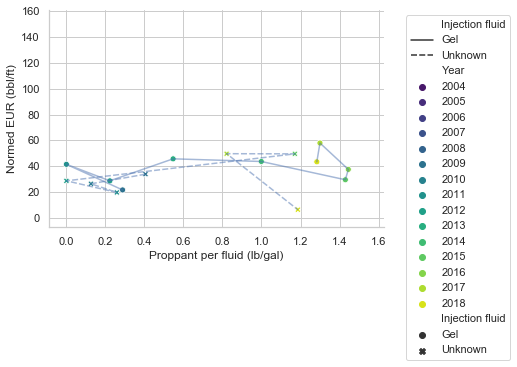

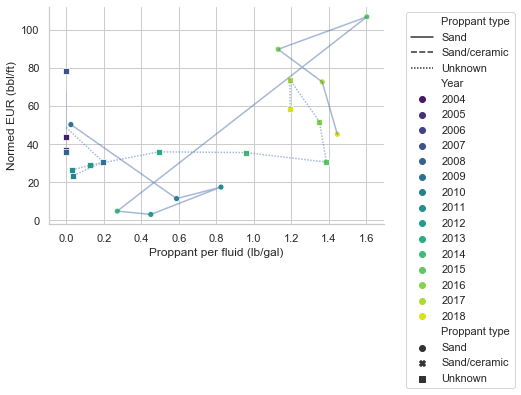

In [35]:
# Fluid type
g = sns.scatterplot(
    "Proppant per fluid (lb/gal)",
    "Normed EUR (bbl/ft)",
    hue="Year",
    style="Injection fluid",
    data=t_byfluid,
    palette=sns.color_palette("viridis", len(t_byproppant.Year.unique())),
    style_order=["Gel", "Unknown"],
    legend="brief",
)
g = sns.lineplot(
    "Proppant per fluid (lb/gal)",
    "Normed EUR (bbl/ft)",
    style="Injection fluid",
    data=t_byfluid,
    sort=False,
    style_order=["Gel", "Unknown"],  # legend=False,
    alpha=0.5,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.savefig(
    wdir + "Average_EUR_v_proppant_intensity_v_inj.png", dpi=300, bbox_inches="tight"
)

## Proppant type
plt.figure()

g = sns.scatterplot(
    "Proppant per fluid (lb/gal)",
    "Normed EUR (bbl/ft)",
    hue="Year",
    style="Proppant type",
    data=t_byproppant,
    palette=sns.color_palette("viridis", len(t_byproppant.Year.unique())),
    style_order=["Sand", "Sand/ceramic", "Unknown"],
)
g = sns.lineplot(
    "Proppant per fluid (lb/gal)",
    "Normed EUR (bbl/ft)",
    style="Proppant type",
    data=t_byproppant,
    sort=False,
    style_order=["Sand", "Sand/ceramic", "Unknown"],  # legend=False,
    alpha=0.5,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.savefig(
    wdir + "Average_EUR_v_proppant_intensity_v_prop.png", dpi=300, bbox_inches="tight"
)

## EUR per length vs water cut


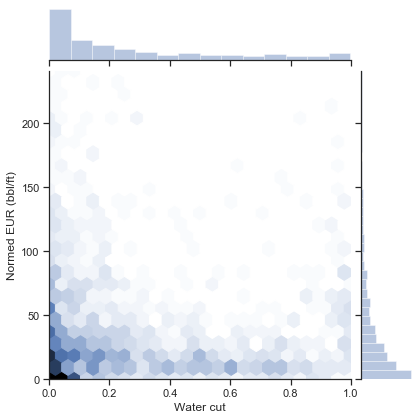

In [36]:
t = df.query("liquids_eur_length < @df.liquids_eur_length.quantile(.99)").rename(
    columns=col_rename_dict
)
with sns.axes_style("ticks"):
    sns.jointplot(
        "Water cut",
        "Normed EUR (bbl/ft)",
        data=t,
        kind="hexbin",
        xlim=(0, 1),
        ylim=(0, t["Normed EUR (bbl/ft)"].max()),
    )
    plt.savefig(wdir + "EUR_v_water_cut.png", dpi=300, bbox_inches="tight")

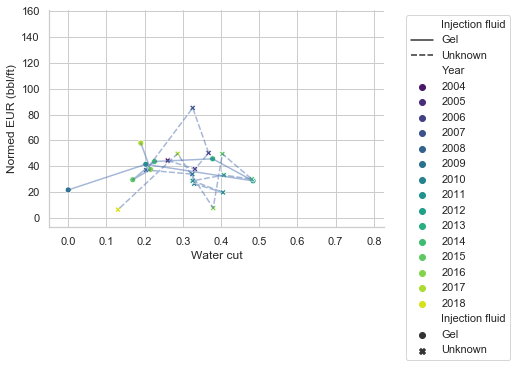

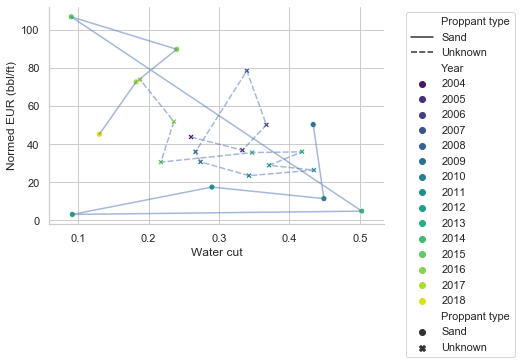

In [37]:
## Fluid type
g = sns.scatterplot(
    "Water cut",
    "Normed EUR (bbl/ft)",
    hue="Year",
    style="Injection fluid",
    data=t_byfluid,
    palette=sns.color_palette("viridis", len(t_byproppant.Year.unique())),
    style_order=["Gel", "Unknown"],
    legend="brief",
)
g = sns.lineplot(
    "Water cut",
    "Normed EUR (bbl/ft)",
    style="Injection fluid",
    data=t_byfluid,
    sort=False,
    style_order=["Gel", "Unknown"],  # legend=False,
    alpha=0.5,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.savefig(wdir + "Average_EUR_v_water_cut_v_prop.png", dpi=300, bbox_inches="tight")

## Proppant type
plt.figure()

g = sns.scatterplot(
    "Water cut",
    "Normed EUR (bbl/ft)",
    hue="Year",
    style="Proppant type",
    data=t_byproppant,
    palette=sns.color_palette("viridis", len(t_byproppant.Year.unique())),
    style_order=["Sand", "Unknown"],
)
g = sns.lineplot(
    "Water cut",
    "Normed EUR (bbl/ft)",
    style="Proppant type",
    data=t_byproppant,
    sort=False,
    style_order=["Sand", "Unknown"],  # legend=False,
    alpha=0.5,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.savefig(wdir + "Average_EUR_v_water_cut_v_inj.png", dpi=300, bbox_inches="tight")

## Tau vs Proppant intensity

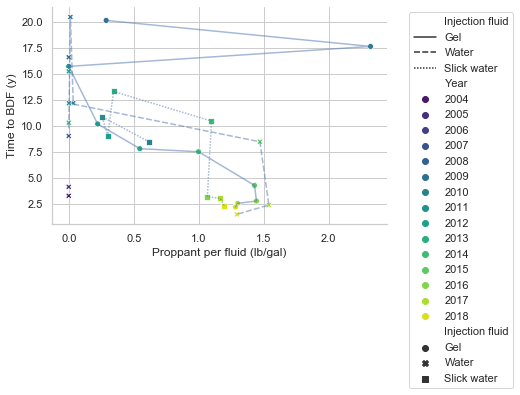

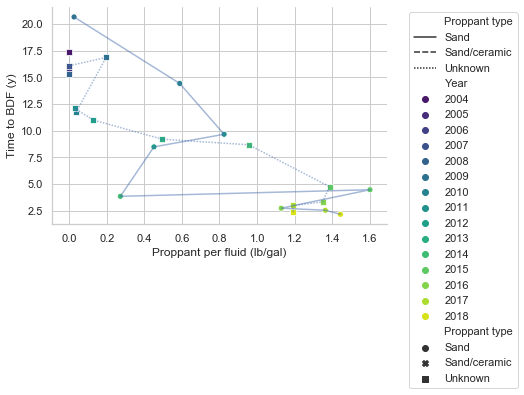

In [38]:
## Fluid type
g = sns.scatterplot(
    "Proppant per fluid (lb/gal)",
    "Time to BDF (y)",
    hue="Year",
    style="Injection fluid",
    data=t_byfluid,
    palette=sns.color_palette("viridis", len(t_byproppant.Year.unique())),
    style_order=["Gel", "Water", "Slick water"],
    legend="brief",
)
g = sns.lineplot(
    "Proppant per fluid (lb/gal)",
    "Time to BDF (y)",
    style="Injection fluid",
    data=t_byfluid,
    sort=False,
    style_order=["Gel", "Water", "Slick water"],  # legend=False,
    alpha=0.5,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.savefig(
    wdir + "Average_tau_v_proppant_intensity_v_inj.png", dpi=300, bbox_inches="tight"
)

## Proppant type
plt.figure()
g = sns.scatterplot(
    "Proppant per fluid (lb/gal)",
    "Time to BDF (y)",
    hue="Year",
    style="Proppant type",
    data=t_byproppant,
    palette=sns.color_palette("viridis", len(t_byproppant.Year.unique())),
    style_order=["Sand", "Sand/ceramic", "Unknown"],
)
g = sns.lineplot(
    "Proppant per fluid (lb/gal)",
    "Time to BDF (y)",
    style="Proppant type",
    data=t_byproppant,
    sort=False,
    style_order=["Sand", "Sand/ceramic", "Unknown"],  # legend=False,
    alpha=0.5,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.savefig(
    wdir + "Average_tau_v_proppant_intensity_v_prop.png", dpi=300, bbox_inches="tight"
)

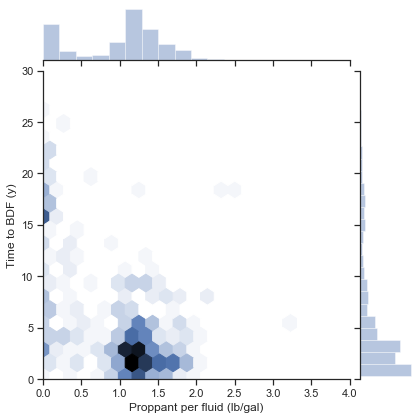

In [39]:
t = df[df.tau_y < 30].rename(columns=col_rename_dict)
with sns.axes_style("ticks"):
    sns.jointplot(
        "Proppant per fluid (lb/gal)",
        "Time to BDF (y)",
        data=t,
        kind="hexbin",
        xlim=(0, 4),
        ylim=(0, 30),
    )

## GOR vs watercut and $\tau$

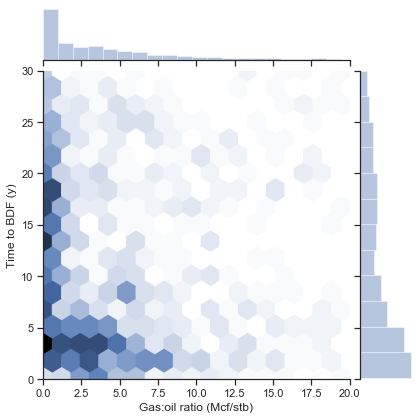

In [40]:
xmax = 20
t = df[df.tau_y < 30].query(f"gor<{xmax}").rename(columns=col_rename_dict)
with sns.axes_style("ticks"):
    sns.jointplot(
        "Gas:oil ratio (Mcf/stb)",
        "Time to BDF (y)",
        data=t,
        kind="hexbin",
        xlim=(0, xmax),
        ylim=(0, 30),
    )

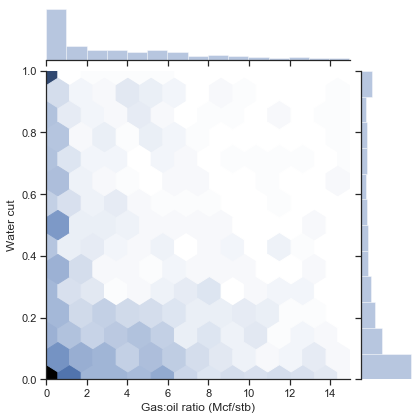

In [39]:
xmax = 15
t = df.query(f"gor<{xmax}").rename(columns=col_rename_dict)
with sns.axes_style("ticks"):
    sns.jointplot(
        "Gas:oil ratio (Mcf/stb)",
        "Water cut",
        data=t,
        kind="hexbin",
        xlim=(0, xmax),
        ylim=(0, 1),
    )

In [40]:
df["gor"].describe()
df["gor"].quantile(0.90)

36.71645800399374

(196, 75)


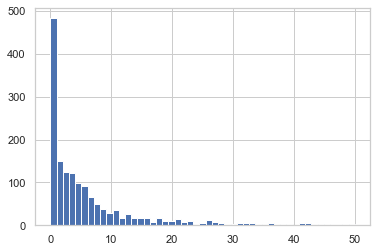

In [41]:
df["gor"].hist(bins=np.linspace(0, 50, 50))
print(df[df.gor > 30].shape)

<Figure size 432x288 with 0 Axes>

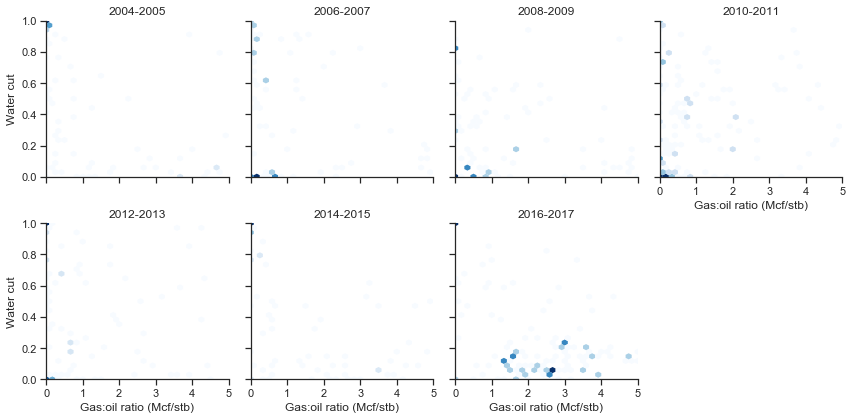

In [42]:
xmax = 5
t = (
    df.query(f"gor<{xmax}")
    .query("comp_year>2003 & comp_year<2018")
    .assign(Years=lambda x: x["comp_year"] // 2 * 2)
    .assign(
        Years=lambda x: x.Years.astype(str).str[:-2]
        + "-"
        + (x.Years + 1).astype(str).str[:-2]
    )
    .rename(columns=col_rename_dict)
)

with sns.axes_style("ticks"):
    plt.figure()
    # sns.jointplot('Fluid intensity (gal/ft)', 'Normed EUR (bbl/ft)', data=t, kind='hexbin',xlim=(0,1.5e3), ylim=(0,120))
    g = sns.FacetGrid(
        t,
        col="Years",
        col_wrap=4,
        xlim=(0, xmax),
        ylim=(0, 1),
        col_order=t.Years.sort_values().unique(),
    )
    g.map(
        plt.hexbin,
        "Gas:oil ratio (Mcf/stb)",
        "Water cut",
        extent=[0, xmax, 0, 1],
        gridsize=30,
        cmap="Blues",
        mincnt=1,
        linewidths=0,
    )
    g.set_titles("{col_name}")
    plt.savefig(wdir + "WC_v_GOR.png", dpi=300, bbox_inches="tight")

## GOR vs EUR

<Figure size 432x288 with 0 Axes>

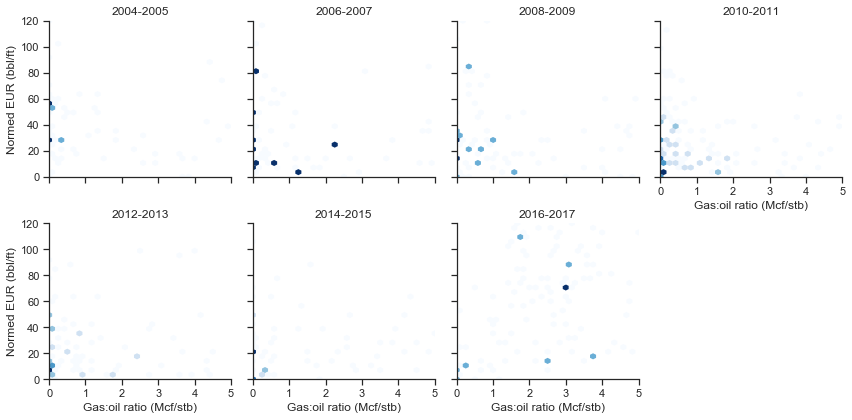

In [43]:
xmax = 5
ymax = 120
t = (
    df.query(f"gor<{xmax}")
    .query("comp_year>2003 & comp_year<2018")
    .assign(Years=lambda x: x["comp_year"] // 2 * 2)
    .assign(
        Years=lambda x: x.Years.astype(str).str[:-2]
        + "-"
        + (x.Years + 1).astype(str).str[:-2]
    )
    .rename(columns=col_rename_dict)
)

with sns.axes_style("ticks"):
    plt.figure()
    # sns.jointplot('Fluid intensity (gal/ft)', 'Normed EUR (bbl/ft)', data=t, kind='hexbin',xlim=(0,1.5e3), ylim=(0,120))
    g = sns.FacetGrid(
        t,
        col="Years",
        col_wrap=4,
        xlim=(0, xmax),
        ylim=(0, ymax),
        col_order=t.Years.sort_values().unique(),
    )
    g.map(
        plt.hexbin,
        "Gas:oil ratio (Mcf/stb)",
        "Normed EUR (bbl/ft)",
        extent=[0, xmax, 0, ymax],
        gridsize=30,
        cmap="Blues",
        mincnt=1,
        linewidths=0,
    )
    g.set_titles("{col_name}")
    plt.savefig(wdir + "EUR_v_GOR.png", dpi=300, bbox_inches="tight")

## First year cumulative production plots

In [44]:
cum_df = (
    pd.read_feather("oil_cumulatives.feather")
    .assign(API=lambda x: x.API.astype(str))
    .set_index("API")
    .drop(columns=["start_date", "liquids_eur"])
    .join(df)
)

<Figure size 432x288 with 0 Axes>

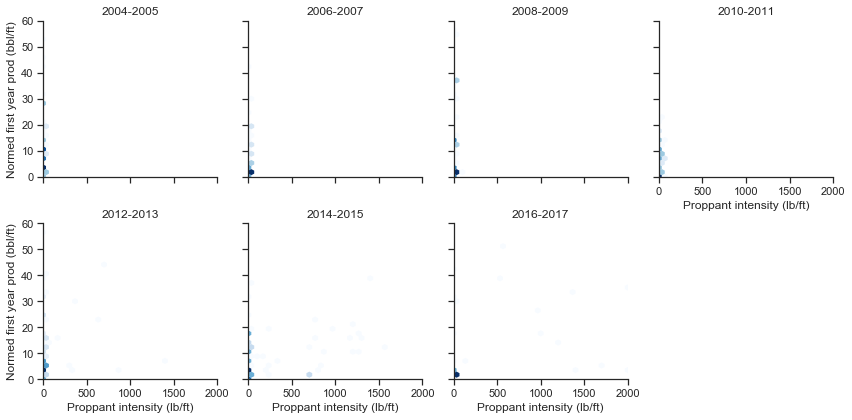

In [45]:
t = (
    cum_df.query(f"gor<{xmax}")
    .query("comp_year>2003 & comp_year<2018")
    .assign(Years=lambda x: x["comp_year"] // 2 * 2)
    .assign(
        Years=lambda x: x.Years.astype(str).str[:-2]
        + "-"
        + (x.Years + 1).astype(str).str[:-2]
    )
    .rename(columns=col_rename_dict)
)
t["Normed first year prod (bbl/ft)"] = t["cum_12m"] / t["Lateral length (ft)"]

xmax = 2e3
ymax = 60
with sns.axes_style("ticks"):
    plt.figure()
    # sns.jointplot('Fluid intensity (gal/ft)', 'Normed EUR (bbl/ft)', data=t, kind='hexbin',xlim=(0,1.5e3), ylim=(0,120))
    g = sns.FacetGrid(
        t,
        col="Years",
        col_wrap=4,
        xlim=(0, xmax),
        ylim=(0, ymax),
        col_order=t.Years.sort_values().unique(),
    )
    g.map(
        plt.hexbin,
        "Proppant intensity (lb/ft)",
        "Normed first year prod (bbl/ft)",
        extent=[0, xmax, 0, ymax],
        gridsize=30,
        cmap="Blues",
        mincnt=1,
        linewidths=0,
    )
    g.set_titles("{col_name}")
    plt.savefig(wdir + "12mcum_v_proppant.png", dpi=300, bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

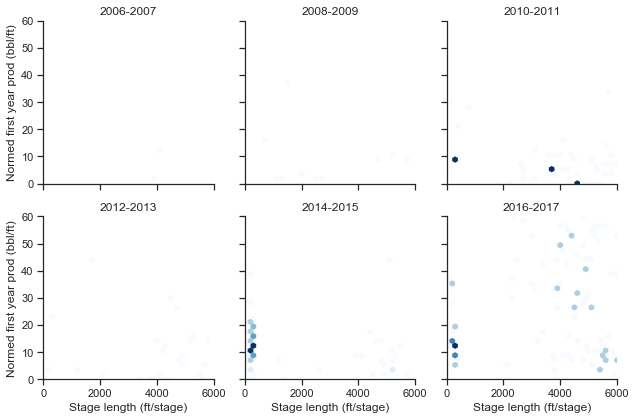

In [46]:
t = (
    cum_df.query(f"gor<{xmax}")
    .query("comp_year>2003 & comp_year<2018")
    .assign(Years=lambda x: x["comp_year"] // 2 * 2)
    .assign(
        Years=lambda x: x.Years.astype(str).str[:-2]
        + "-"
        + (x.Years + 1).astype(str).str[:-2]
    )
    .rename(columns=col_rename_dict)
)
t["Normed first year prod (bbl/ft)"] = t["cum_12m"] / t["Lateral length (ft)"]
t["Stage length (ft/stage)"] = t["Lateral length (ft)"] / t["stages_number"].replace(
    0, 1
)

xmax = 6e3
ymax = 60
with sns.axes_style("ticks"):
    plt.figure()
    # sns.jointplot('Fluid intensity (gal/ft)', 'Normed EUR (bbl/ft)', data=t, kind='hexbin',xlim=(0,1.5e3), ylim=(0,120))
    g = sns.FacetGrid(
        t,
        col="Years",
        col_wrap=3,
        xlim=(0, xmax),
        ylim=(0, ymax),
        col_order=t.Years.sort_values().unique()[1:],
    )
    g.map(
        plt.hexbin,
        "Stage length (ft/stage)",
        "Normed first year prod (bbl/ft)",
        extent=[0, xmax, 0, ymax],
        gridsize=30,
        cmap="Blues",
        mincnt=1,
        linewidths=0,
    )
    g.set_titles("{col_name}")
    plt.savefig(wdir + "12mcum_v_stagelength.png", dpi=300, bbox_inches="tight")

# EIA rig counts

In [47]:
pd.ExcelFile("../../multibasin_data/rig counts-EIA-2019-6-10.xlsx").sheet_names

['Anadarko Region',
 'Appalachia Region',
 'Bakken Region',
 'Eagle Ford Region',
 'Haynesville Region',
 'Niobrara Region',
 'Permian Region',
 'RegionCounties']

In [48]:
rigs = (
    pd.read_excel(
        "../../multibasin_data/rig counts-EIA-2019-6-10.xlsx",
        sheet_name="Eagle Ford Region",
        header=(1),
    )
    .rename(columns=lambda x: x.replace(".1", " gas"))
    .set_index("Month")
)

rigs.head()

,Rig count,Production per rig,Legacy production change,Total production,Production per rig gas,Legacy production change gas,Total production gas
Month,,,,,,,
2007-01-01,51.0,44.278384,-1944.1358,53993.8064,1270.41148,-53051.652,1599376.80
2007-02-01,56.0,42.963569,-1939.0657,56284.6785,1243.39787,-54185.339,1651074.92
2007-03-01,58.0,41.751291,-1933.7846,54825.6451,1220.34297,-55178.735,1657453.12
2007-04-01,56.0,40.385237,-1927.7938,56724.8666,1196.59532,-56251.943,1669511.36
2007-05-01,55.0,39.061878,-1922.5117,56680.3548,1175.41009,-57272.740,1634131.29


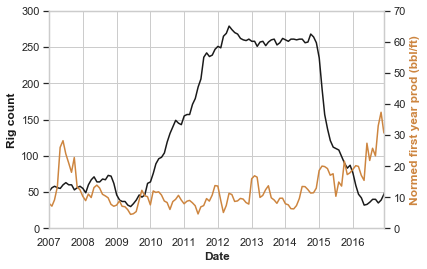

In [49]:
t = (
    cum_df.query(f"gor<{xmax}")
    .query("comp_year>2003 & comp_year<2018")
    .assign(Years=lambda x: x["comp_year"] // 2 * 2)
    .assign(
        Years=lambda x: x.Years.astype(str).str[:-2]
        + "-"
        + (x.Years + 1).astype(str).str[:-2]
    )
    .rename(columns=col_rename_dict)
)
t["Normed first year prod (bbl/ft)"] = t["cum_12m"] / t["Lateral length (ft)"]
tn = (
    t.groupby("start_date")["Normed first year prod (bbl/ft)"]
    .mean()
    .rolling(3, center=True)
    .mean()
)


plt.plot(rigs["Rig count"], color="k")
plt.ylabel("Rig count", color="k", fontweight="bold")
plt.xlabel("Date", fontweight="bold")
plt.ylim(0, 300)
plt.twinx()
plt.plot(tn, color="peru")
plt.ylim(0, 70)
plt.ylabel("Normed first year prod (bbl/ft)", color="peru", fontweight="bold")

plt.xlim(*pd.to_datetime(["2007-1-1", "2016-12-1"]))

plt.grid(False, axis="y")